In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv("data.csv")

mapping = {
    "T_Cell": 0,
    "Cancer": 1,
    "Fibroblast": 2
}

df["label"] = df["Cell_Type"].map(mapping)
print(len(df))
df.head()

3000


C:\Users\Wesam\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


,Cell_ID,Cell_Type,Disease_Status,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1,label
0,C0001,T_Cell,Tumor,5.565866,4.546474,10.532535,2.113285,0.951138,9.580415,7.818137,0
1,C0002,T_Cell,Tumor,5.351163,3.840752,10.642705,4.361618,0.952454,10.540695,8.298277,0
2,C0003,T_Cell,Tumor,4.935363,2.271616,10.389736,2.839926,1.906194,8.416975,7.158779,0
3,C0004,Cancer,Tumor,4.095084,14.881377,3.268237,3.204284,9.922546,7.357785,0.016234,1
4,C0005,Fibroblast,Tumor,4.669715,5.444694,2.561298,14.046708,3.126553,3.372407,11.646391,2


In [2]:
df.columns

Index(['Cell_ID', 'Cell_Type', 'Disease_Status', 'Gene_E_Housekeeping',
       'Gene_A_Oncogene', 'Gene_B_Immune', 'Gene_C_Stromal', 'Gene_D_Therapy',
       'Pathway_Score_Inflam', 'UMAP_1', 'label'],
      dtype='object')

In [3]:
cat_cols = ['Disease_Status']
cont_cols = ['Gene_E_Housekeeping','Gene_A_Oncogene', 'Gene_B_Immune', 'Gene_C_Stromal', 'Gene_D_Therapy']
y_col = ['label']

In [4]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [5]:
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
df.head()

,Cell_ID,Cell_Type,Disease_Status,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1,label
0,C1723,Fibroblast,Tumor,5.131421,4.776977,2.106076,16.552165,5.164179,3.412056,10.659367,2
1,C2870,T_Cell,Tumor,5.146689,2.257734,11.051999,4.192739,2.638028,7.304043,5.071046,0
2,C0827,Fibroblast,Tumor,4.829643,4.015499,4.812004,15.220742,3.859063,3.091341,10.776105,2
3,C0276,T_Cell,Tumor,5.361335,5.195182,11.810257,4.575532,2.415842,14.906729,6.665863,0
4,C2211,T_Cell,Tumor,4.548431,2.748785,10.956725,2.619282,0.831568,10.548023,5.183784,0


In [6]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1)]

In [7]:
Disease_Status = df['Disease_Status'].cat.codes.values
cats = np.stack([Disease_Status], 1)

cats[:5]
     

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int8)

In [8]:
cats = torch.tensor(cats, dtype=torch.int64)

In [9]:
Gene_E_Housekeeping = df['Gene_E_Housekeeping']
Gene_A_Oncogene = df['Gene_A_Oncogene']
Gene_B_Immune = df['Gene_B_Immune']
Gene_C_Stromal = df['Gene_C_Stromal']
Gene_D_Therapy = df['Gene_D_Therapy']

conts = np.stack([Gene_E_Housekeeping,Gene_A_Oncogene, Gene_B_Immune, Gene_C_Stromal, Gene_D_Therapy], 1)

conts[:5]

array([[ 5.13142058,  4.77697713,  2.10607631, 16.55216455,  5.16417939],
       [ 5.14668947,  2.25773431, 11.05199927,  4.19273924,  2.63802752],
       [ 4.82964275,  4.01549906,  4.81200437, 15.22074244,  3.85906302],
       [ 5.36133498,  5.19518249, 11.81025676,  4.5755318 ,  2.41584226],
       [ 4.54843124,  2.74878533, 10.95672514,  2.61928225,  0.83156771]])

In [10]:
conts = torch.tensor(conts, dtype=torch.float)


In [11]:
y = torch.tensor(df[y_col].values).flatten()

In [12]:
b = 3000   # total batch size
t = 500    # test size
v = 500    # validation size

train_end = b - t - v
val_end = b - t

# categorical features
cat_train = cats[:train_end]
cat_val   = cats[train_end:val_end]
cat_test  = cats[val_end:b]

# continuous features
con_train = conts[:train_end]
con_val   = conts[train_end:val_end]
con_test  = conts[val_end:b]

# targets
y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:b]

In [13]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [14]:
# CODE HERE
model = TabularModel(emb_szs, conts.shape[1], 3, [50], p=0.4)

# RUN THIS CODE TO COMPARE RESULTS
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
import time
import torch

start_time = time.time()
epochs = 300
losses = []
val_losses = []  # to store validation losses

for i in range(epochs):
    model.train()  # ensure model is in training mode
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation loss (no gradient computation)
    model.eval()  # switch to evaluation mode
    with torch.no_grad():
        y_val_pred = model(cat_test, con_test)
        val_loss = criterion(y_val_pred, y_test)
        val_losses.append(val_loss.item())
    
    # Print every 25 epochs
    if i % 25 == 0:
        print(f'Epoch {i:3} | Train Loss: {loss.item():10.8f} | Val Loss: {val_loss.item():10.8f}')

print(f'Final Train Loss: {loss.item():10.8f} | Final Val Loss: {val_loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch   0 | Train Loss: 1.55136693 | Val Loss: 1.39730203
Epoch  25 | Train Loss: 0.72620833 | Val Loss: 0.68801785
Epoch  50 | Train Loss: 0.33707014 | Val Loss: 0.29795209
Epoch  75 | Train Loss: 0.16978028 | Val Loss: 0.13676189
Epoch 100 | Train Loss: 0.09539507 | Val Loss: 0.07210729
Epoch 125 | Train Loss: 0.05937300 | Val Loss: 0.04231937
Epoch 150 | Train Loss: 0.04372157 | Val Loss: 0.02725707
Epoch 175 | Train Loss: 0.03027205 | Val Loss: 0.01883956
Epoch 200 | Train Loss: 0.02286352 | Val Loss: 0.01373232
Epoch 225 | Train Loss: 0.01784190 | Val Loss: 0.01042623
Epoch 250 | Train Loss: 0.01499692 | Val Loss: 0.00829003
Epoch 275 | Train Loss: 0.01115982 | Val Loss: 0.00678689
Final Train Loss: 0.01022158 | Final Val Loss: 0.00577734

Duration: 1 seconds


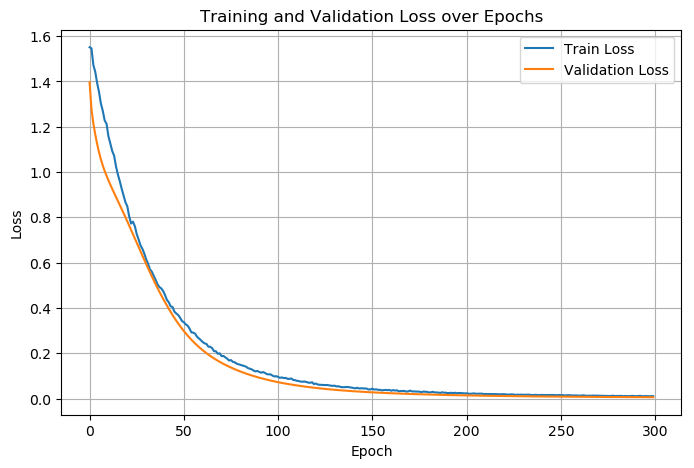

In [17]:
plt.figure(figsize=(8,5))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


500 out of 500 = 100.00% correct
CE Loss: 0.00577734


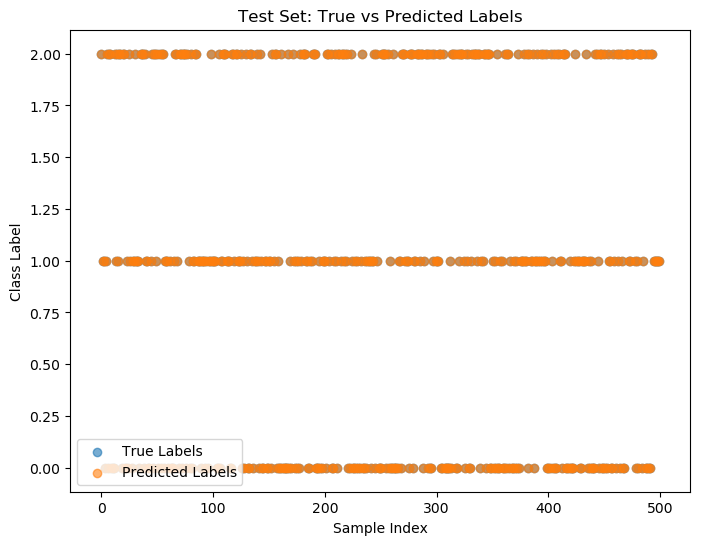

In [18]:
model.eval()
with torch.no_grad():
    y_val = model(cat_test, con_test)        # predictions
    val_loss = criterion(y_val, y_test)      # compute CE loss

# Compute accuracy
pred_classes = y_val.argmax(dim=1)           # get predicted class indices
correct = (pred_classes == y_test).sum().item()  # count correct predictions
total = y_test.size(0)

print(f'\n{correct} out of {total} = {100*correct/total:.2f}% correct')
print(f'CE Loss: {val_loss.item():.8f}')


y_true_np = y_test.cpu().numpy()
y_pred_np = pred_classes.cpu().numpy()

plt.figure(figsize=(8,6))
plt.scatter(range(len(y_true_np)), y_true_np, label='True Labels', alpha=0.6)
plt.scatter(range(len(y_pred_np)), y_pred_np, label='Predicted Labels', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title('Test Set: True vs Predicted Labels')
plt.legend()
plt.show()